# Setup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 
from sklearn.metrics import accuracy_score, hamming_loss, f1_score


import config as cfg
from utils import plot, utils

In [41]:

model_name = f"{cfg.model_name}-stage2-v1-best"

metrics = {'meta': {
                "experiment": cfg.experiment_name,
                "model_name": model_name,
                "date": cfg.run_date,
                "model": cfg.model.__name__,
                },
           'data': {
                "train": cfg.train,
                "validation": cfg.validation,
                "test": cfg.test,
           },
           'results': {
               'train': {}, 'validation': {}, 'test': {}}
               
           }

In [42]:
print(metrics)

{'meta': {'experiment': 'original_w_negative', 'model_name': 'resnet18-stage2-v1-best', 'date': '2020_01_14', 'model': 'resnet18'}, 'data': {'train': 'data/CSVs/train_multilabel.csv', 'validation': 'data/CSVs/validation_multilabel.csv', 'test': 'data/CSVs/test_multilabel.csv'}, 'results': {'train': {}, 'validation': {}, 'test': {}}}


In [10]:
train = pd.read_csv(cfg.train)
validation = pd.read_csv(cfg.validation)
df = pd.concat([train, validation])
df.reset_index(inplace=True, drop=True)

assert df.shape[0] == train.shape[0] + validation.shape[0]

test = pd.read_csv(cfg.test)

In [11]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = (ImageList.from_df(path=cfg.img_path, df=df)
       .split_by_idx(valid_idx=range(train.shape[0], df.shape[0]))
       .label_from_df(cols='label', label_delim=' '))

src_test = (ImageList.from_df(path=cfg.img_path_test, df=test, folder='hold-out')
            .split_none()
            .label_from_df(label_delim=' '))

In [12]:
type(src)

<class 'fastai.data_block.LabelLists'>

In [13]:
data = (src.transform(tfms, size=cfg.image_size)
        .databunch().normalize(imagenet_stats))

data_test = (src_test.transform(tfms, size=cfg.image_size)
        .databunch().normalize(imagenet_stats))

acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, cfg.model, metrics=[acc_05, f_score])

In [15]:
learn = learn.load(os.path.join(cfg.model_dir,
                                model_name))

# Train and Validation

### Get predictions

In [16]:
train_preds, train_y, train_losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)

In [17]:
valid_preds, valid_y, valid_losses = learn.get_preds(with_loss=True)

In [18]:
torch.save(train_preds, os.path.join(cfg.data_dir, f'{model_name}_train_preds.pt'))
torch.save(train_y, os.path.join(cfg.data_dir, f'{model_name}_train_y.pt'))
torch.save(train_losses, os.path.join(cfg.data_dir, f'{model_name}_train_losses.pt'))

torch.save(valid_preds, os.path.join(cfg.data_dir, f'{model_name}_valid_preds.pt'))
torch.save(valid_y, os.path.join(cfg.data_dir, f'{model_name}_valid_y.pt'))
torch.save(valid_losses, os.path.join(cfg.data_dir, f'{model_name}_valid_losses.pt'))

In [7]:
train_preds = torch.load(os.path.join(cfg.data_dir, f'{model_name}_train_preds.pt'))
train_y = torch.load(os.path.join(cfg.data_dir, f'{model_name}_train_y.pt'))
train_losses = torch.load(os.path.join(cfg.data_dir, f'{model_name}_train_losses.pt'))

valid_preds = torch.load(os.path.join(cfg.data_dir, f'{model_name}_valid_preds.pt'))
valid_y = torch.load(os.path.join(cfg.data_dir, f'{model_name}_valid_y.pt'))
valid_losses = torch.load(os.path.join(cfg.data_dir, f'{model_name}_valid_losses.pt'))

### Calculate Evaluation Metrics

In [43]:
f1_score_micro = partial(f1_score, average='micro')
f1_score_micro.__name__ = 'f1_score'
threshold_metrics = [accuracy_score, hamming_loss, f1_score_micro]

metrics['results']['train']['losses_mean'] = train_losses.mean().item()
metrics['results']['validation']['losses_mean'] = valid_losses.mean().item()
metrics['results']['train']['losses_sum'] = train_losses.sum().item()
metrics['results']['validation']['losses_sum'] = valid_losses.sum().item()

metrics['results']['train'] = {**metrics['results']['train'], **utils.calc_threshold_metric_score(y=train_y,
                                                                      preds=train_preds,
                                                                      metrics=threshold_metrics,
                                                                      classes=learn.data.classes)}


metrics['results']['validation'] = {**metrics['results']['validation'], **utils.calc_threshold_metric_score(y=valid_y, 
                                                                                preds=valid_preds,
                                                                                metrics=threshold_metrics,
                                                                                classes=learn.data.classes)}


### Show a sample of results on the validaiton set

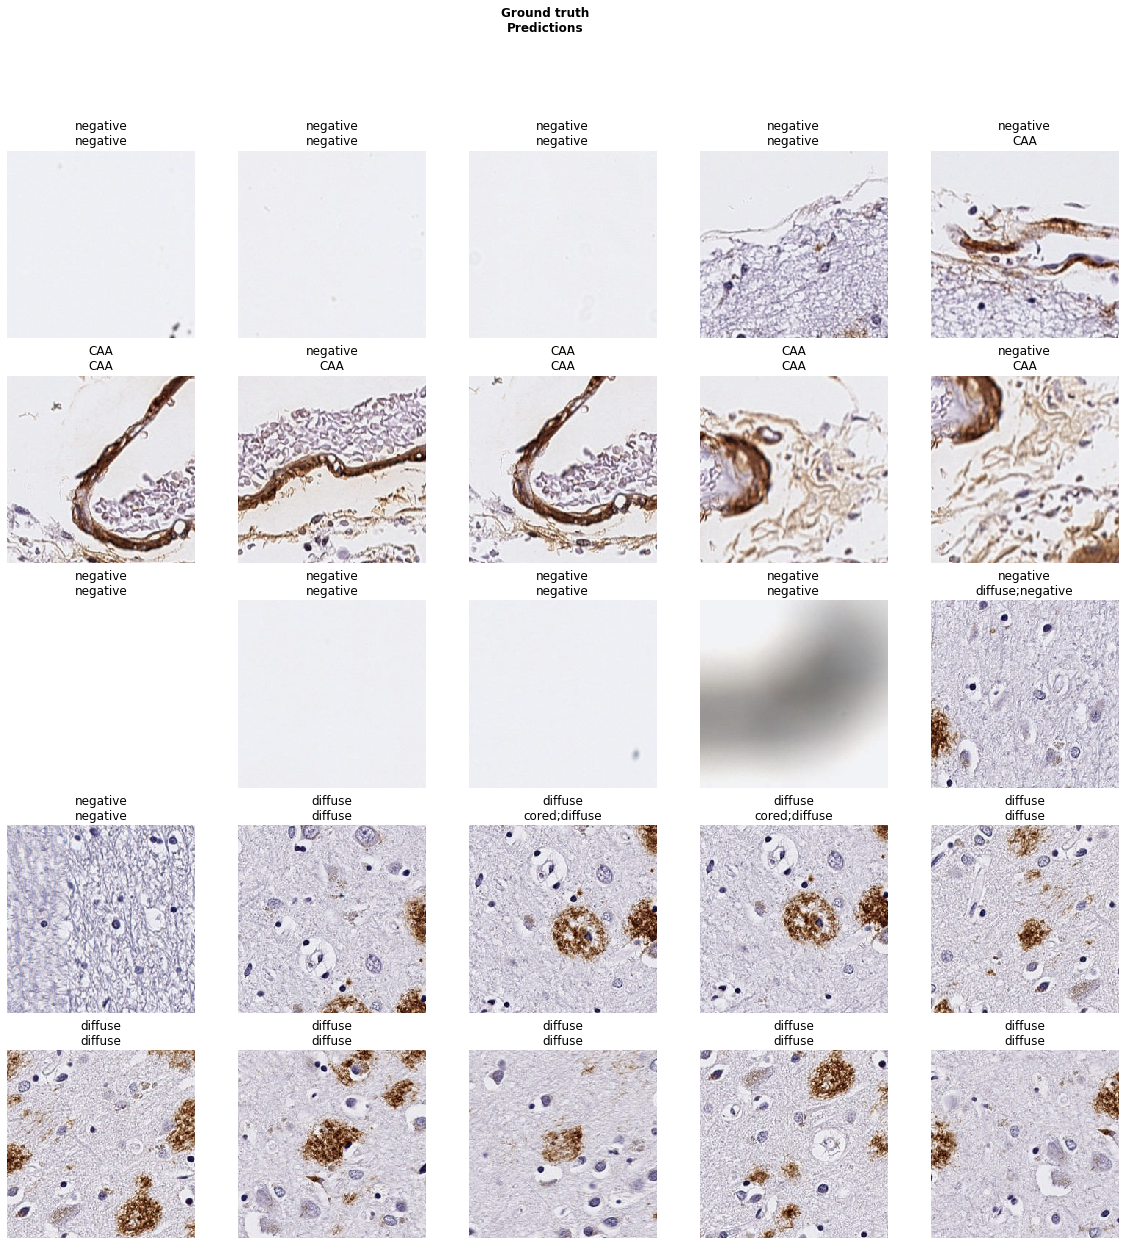

In [20]:
learn.show_results()

### Plot top losses

In [21]:
losses_df = plot.losses_reshape(valid_losses, classes=learn.data.classes)

In [22]:
plot.get_top_agg_losses(losses_df)

CAA         cored   diffuse  negative       loss
6859  1.192093e-07  1.369084e+01  6.503464  0.004601  20.198910
4950  3.576278e-07  1.223820e+01  6.437841  0.001579  18.677622
2063  1.436966e+01  6.031808e-05  4.143740  0.035327  18.548780
4319  2.384186e-07  1.012279e+01  5.472186  0.003303  15.598274
2403  0.000000e+00  9.536739e-07  8.417624  7.149909  15.567533
6069  0.000000e+00  1.192093e-07  7.417025  7.619072  15.036097
5591  7.729609e+00  0.000000e+00  0.000000  6.926512  14.656122
4110  1.311301e-06  0.000000e+00  7.505173  6.808905  14.314079
7555  0.000000e+00  0.000000e+00  8.007595  6.299215  14.306810
4205  1.192093e-07  2.384186e-07  7.397118  6.218208  13.615326

In [23]:
valid_interp = MultiLabelClassificationInterpretation(learn=learn,
                                                      preds=valid_preds,
                                                      y_true=valid_y,
                                                      losses=valid_losses,
                                                      thresh=0.1)

NotImplementedError: 

In [681]:
valid_interp.top_losses(10)

torch.return_types.topk(
values=tensor([11.6453, 10.4130, 10.0293,  9.3002,  9.0926,  9.0717,  8.4163,  8.3975,
         8.3642,  8.2256]),
indices=tensor([ 301, 5591, 4205, 4950, 4110, 4463, 3274, 4983, 2439, 3889]))

In [682]:
valid_interp.confusion_matrix()

array([[0.000e+00, 0.000e+00, 0.000e+00, 4.600e+01, 7.600e+01],
       [3.500e+01, 5.300e+01, 0.000e+00, 3.800e+01, 0.000e+00],
       [4.100e+01, 0.000e+00, 1.740e+02, 1.660e+02, 0.000e+00],
       [8.600e+01, 3.000e+00, 3.800e+01, 7.347e+03, 1.300e+01],
       [1.600e+01, 6.000e+00, 2.000e+00, 2.530e+02, 4.560e+02]], dtype=float32)

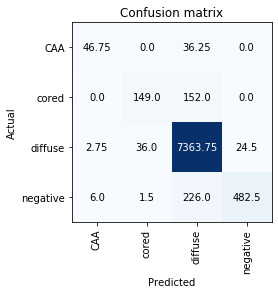

In [829]:
valid_interp.plot_confusion_matrix()

In [823]:
valid_interp.confusion_matrix()

array([[4.67500e+01, 0.00000e+00, 3.62500e+01, 0.00000e+00],
       [0.00000e+00, 1.49000e+02, 1.52000e+02, 0.00000e+00],
       [2.75000e+00, 3.60000e+01, 7.36375e+03, 2.45000e+01],
       [6.00000e+00, 1.50000e+00, 2.26000e+02, 4.82500e+02]], dtype=float32)

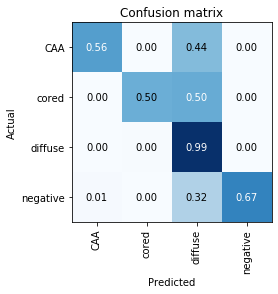

In [825]:
valid_interp.plot_confusion_matrix(normalize=True)

In [812]:

def confusion_matrix_alloc_combinatorial(y_true=None, preds=None, class_len=4):

    cm = torch.zeros(class_len, class_len)

    for (y_i, pred_i) in zip(y_true, preds):
        y_class = y_i.nonzero()
        pred_class = pred_i.nonzero()

        combinatorial = list(itertools.product(y_class, pred_class))
        combinatorial_len = len(combinatorial)
        print(f"combinatorial {combinatorial}")

        for y_i, pred_i in combinatorial:
            print(f"y_i {y_i}, pred_i {pred_i}")
            cm[y_i, pred_i] += (1 / combinatorial_len)




    return(cm)


ym = torch.tensor([
     [1, 1, 1, 1],
     [1, 1, 0, 0],
     [0, 1, 0, 1],
     ])

predsm = torch.tensor([
     [1, 0, 0, 0],
     [1, 1, 1, 1],
     [1, 0, 1, 0],
     ])


confusion_matrix_alloc_combinatorial(y_true=ym, preds=predsm)

combinatorial [(tensor([0]), tensor([0])), (tensor([1]), tensor([0])), (tensor([2]), tensor([0])), (tensor([3]), tensor([0]))]
y_i tensor([0]), pred_i tensor([0])
y_i tensor([1]), pred_i tensor([0])
y_i tensor([2]), pred_i tensor([0])
y_i tensor([3]), pred_i tensor([0])
combinatorial [(tensor([0]), tensor([0])), (tensor([0]), tensor([1])), (tensor([0]), tensor([2])), (tensor([0]), tensor([3])), (tensor([1]), tensor([0])), (tensor([1]), tensor([1])), (tensor([1]), tensor([2])), (tensor([1]), tensor([3]))]
y_i tensor([0]), pred_i tensor([0])
y_i tensor([0]), pred_i tensor([1])
y_i tensor([0]), pred_i tensor([2])
y_i tensor([0]), pred_i tensor([3])
y_i tensor([1]), pred_i tensor([0])
y_i tensor([1]), pred_i tensor([1])
y_i tensor([1]), pred_i tensor([2])
y_i tensor([1]), pred_i tensor([3])
combinatorial [(tensor([1]), tensor([0])), (tensor([1]), tensor([2])), (tensor([3]), tensor([0])), (tensor([3]), tensor([2]))]
y_i tensor([1]), pred_i tensor([0])
y_i tensor([1]), pred_i tensor([2])
y_i

tensor([[0.3750, 0.1250, 0.1250, 0.1250],
        [0.6250, 0.1250, 0.3750, 0.1250],
        [0.2500, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.2500, 0.0000]])

In [24]:
plot.top_losses(preds=valid_preds,
                y=valid_y,
                losses=valid_losses,
                learner=learn)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7faff324a4d0> (for post_execute):


KeyboardInterrupt: 

### Plot top losses - Cored

In [ ]:
plot.top_losses(preds=valid_preds,
                y=valid_y,
                losses=valid_losses,
                learner=learn,
                target_class='cored')

### ROC PRC Curve Plot

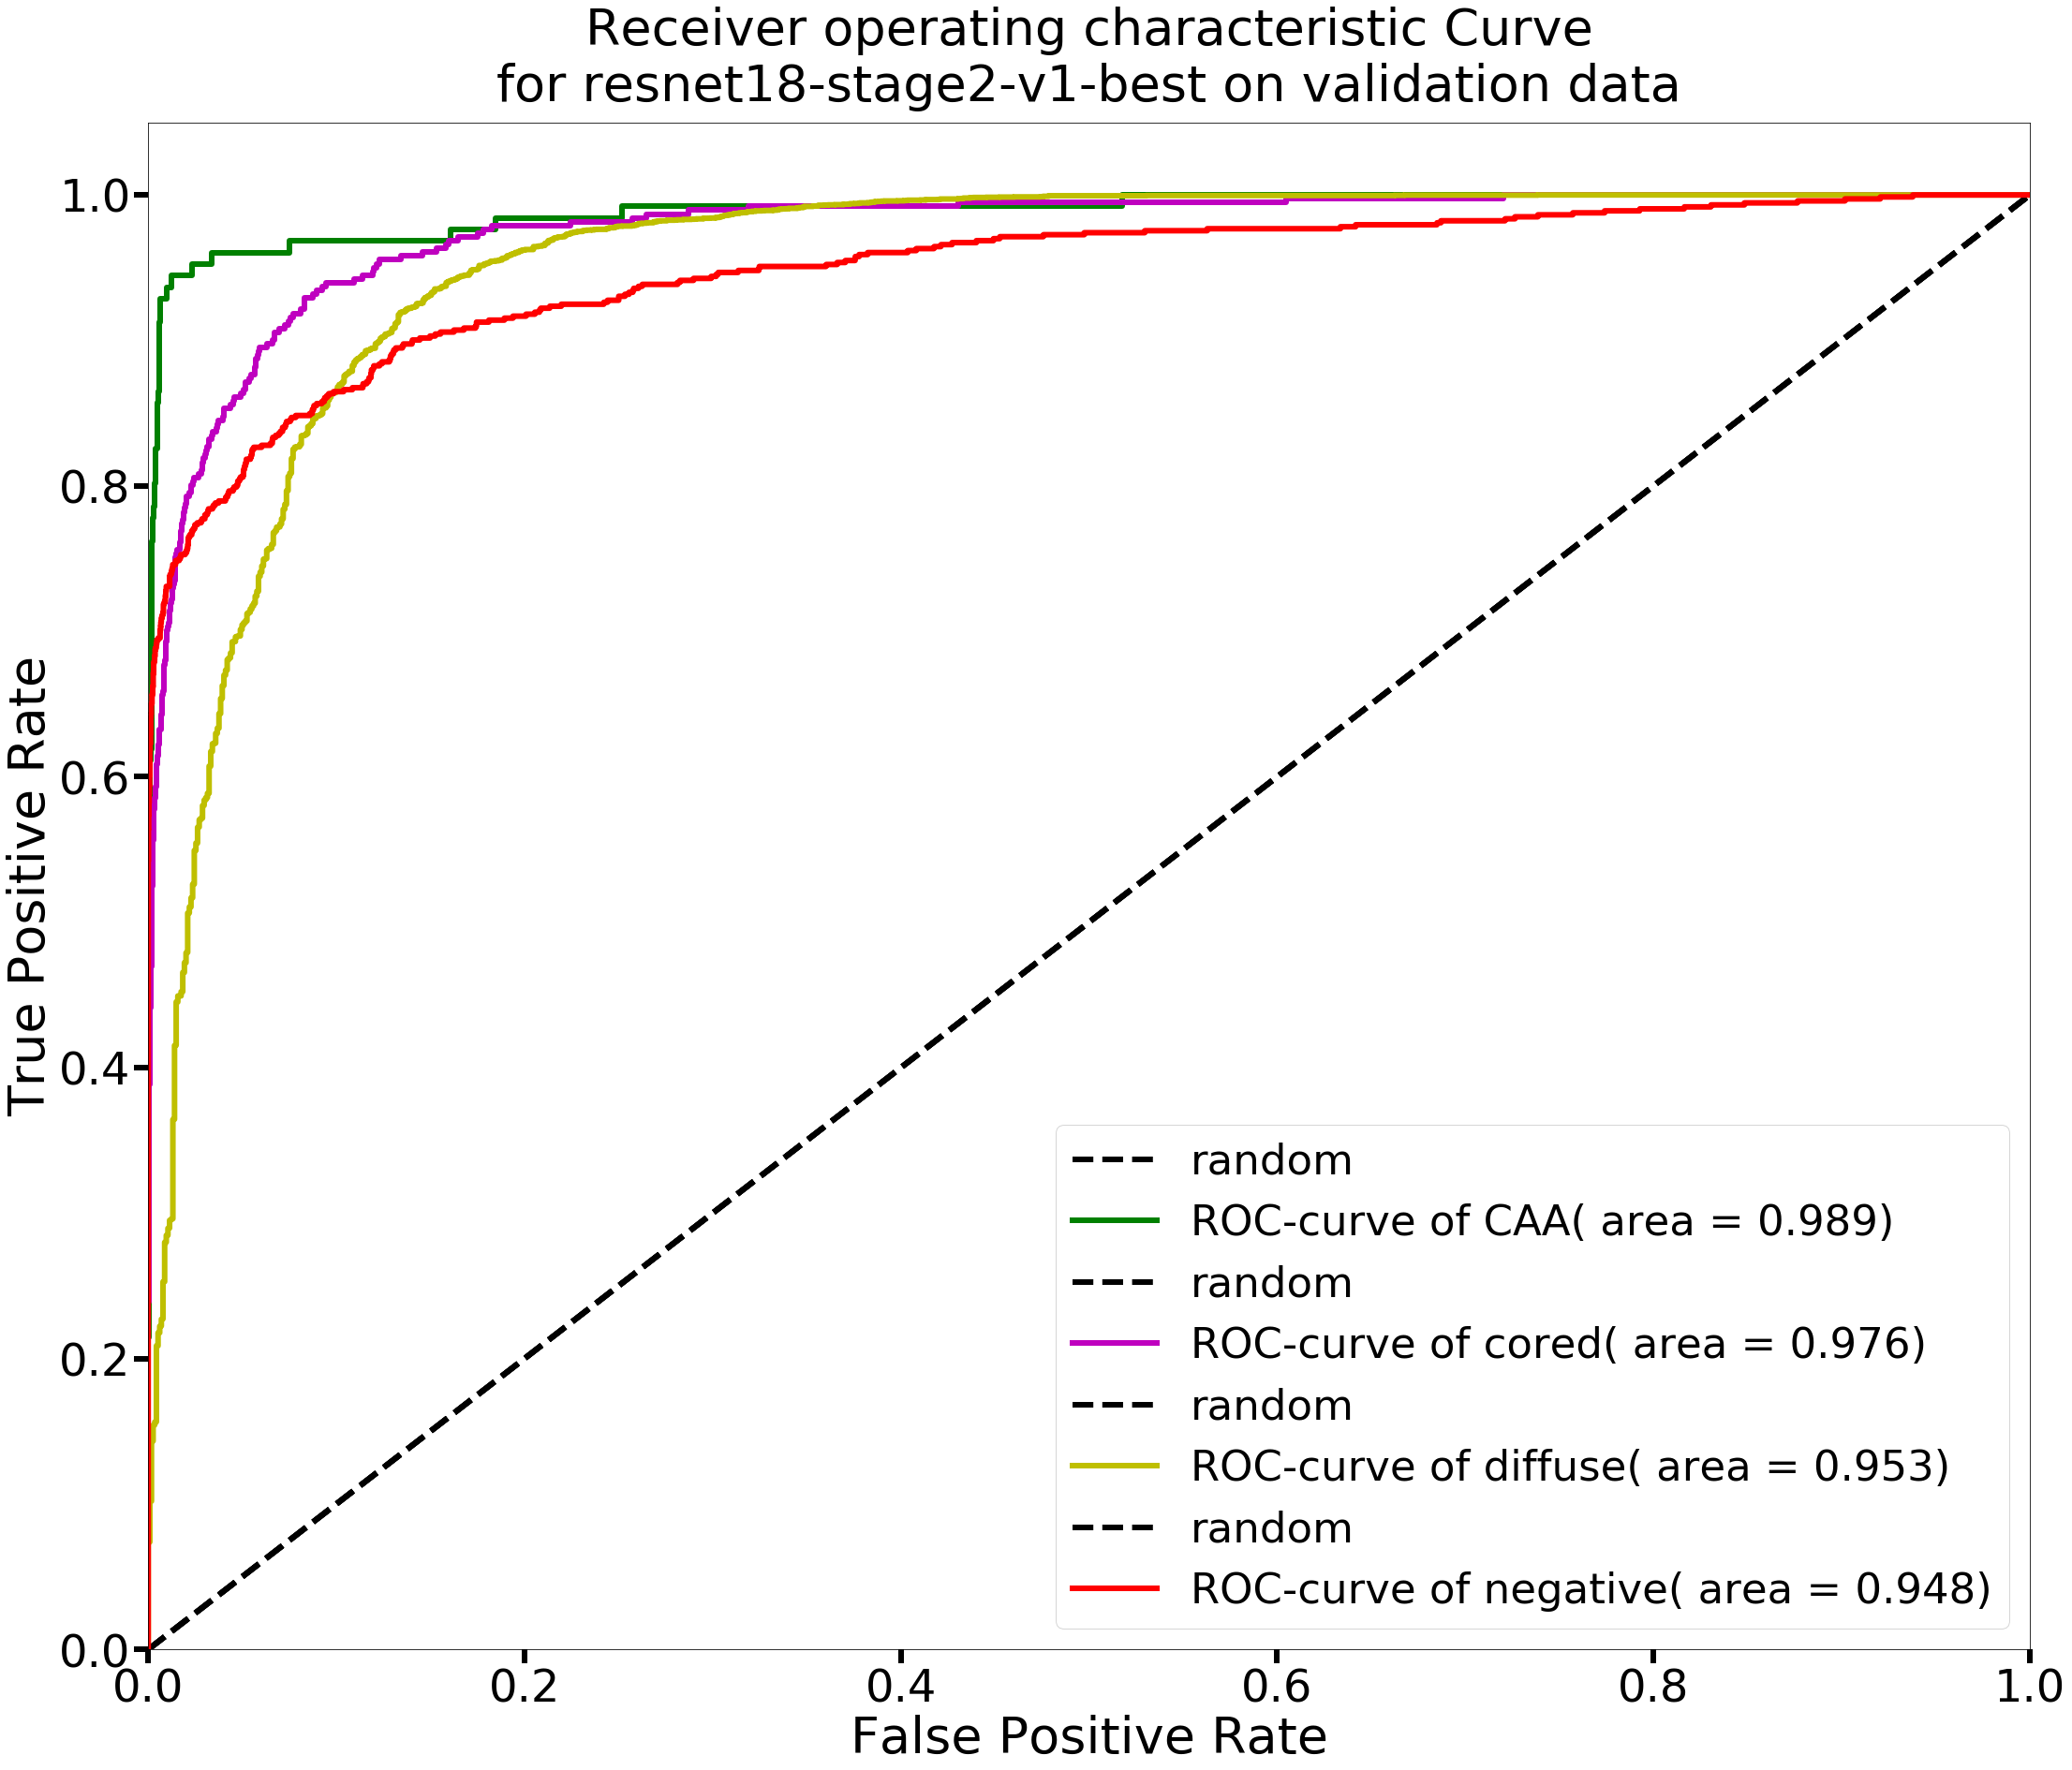

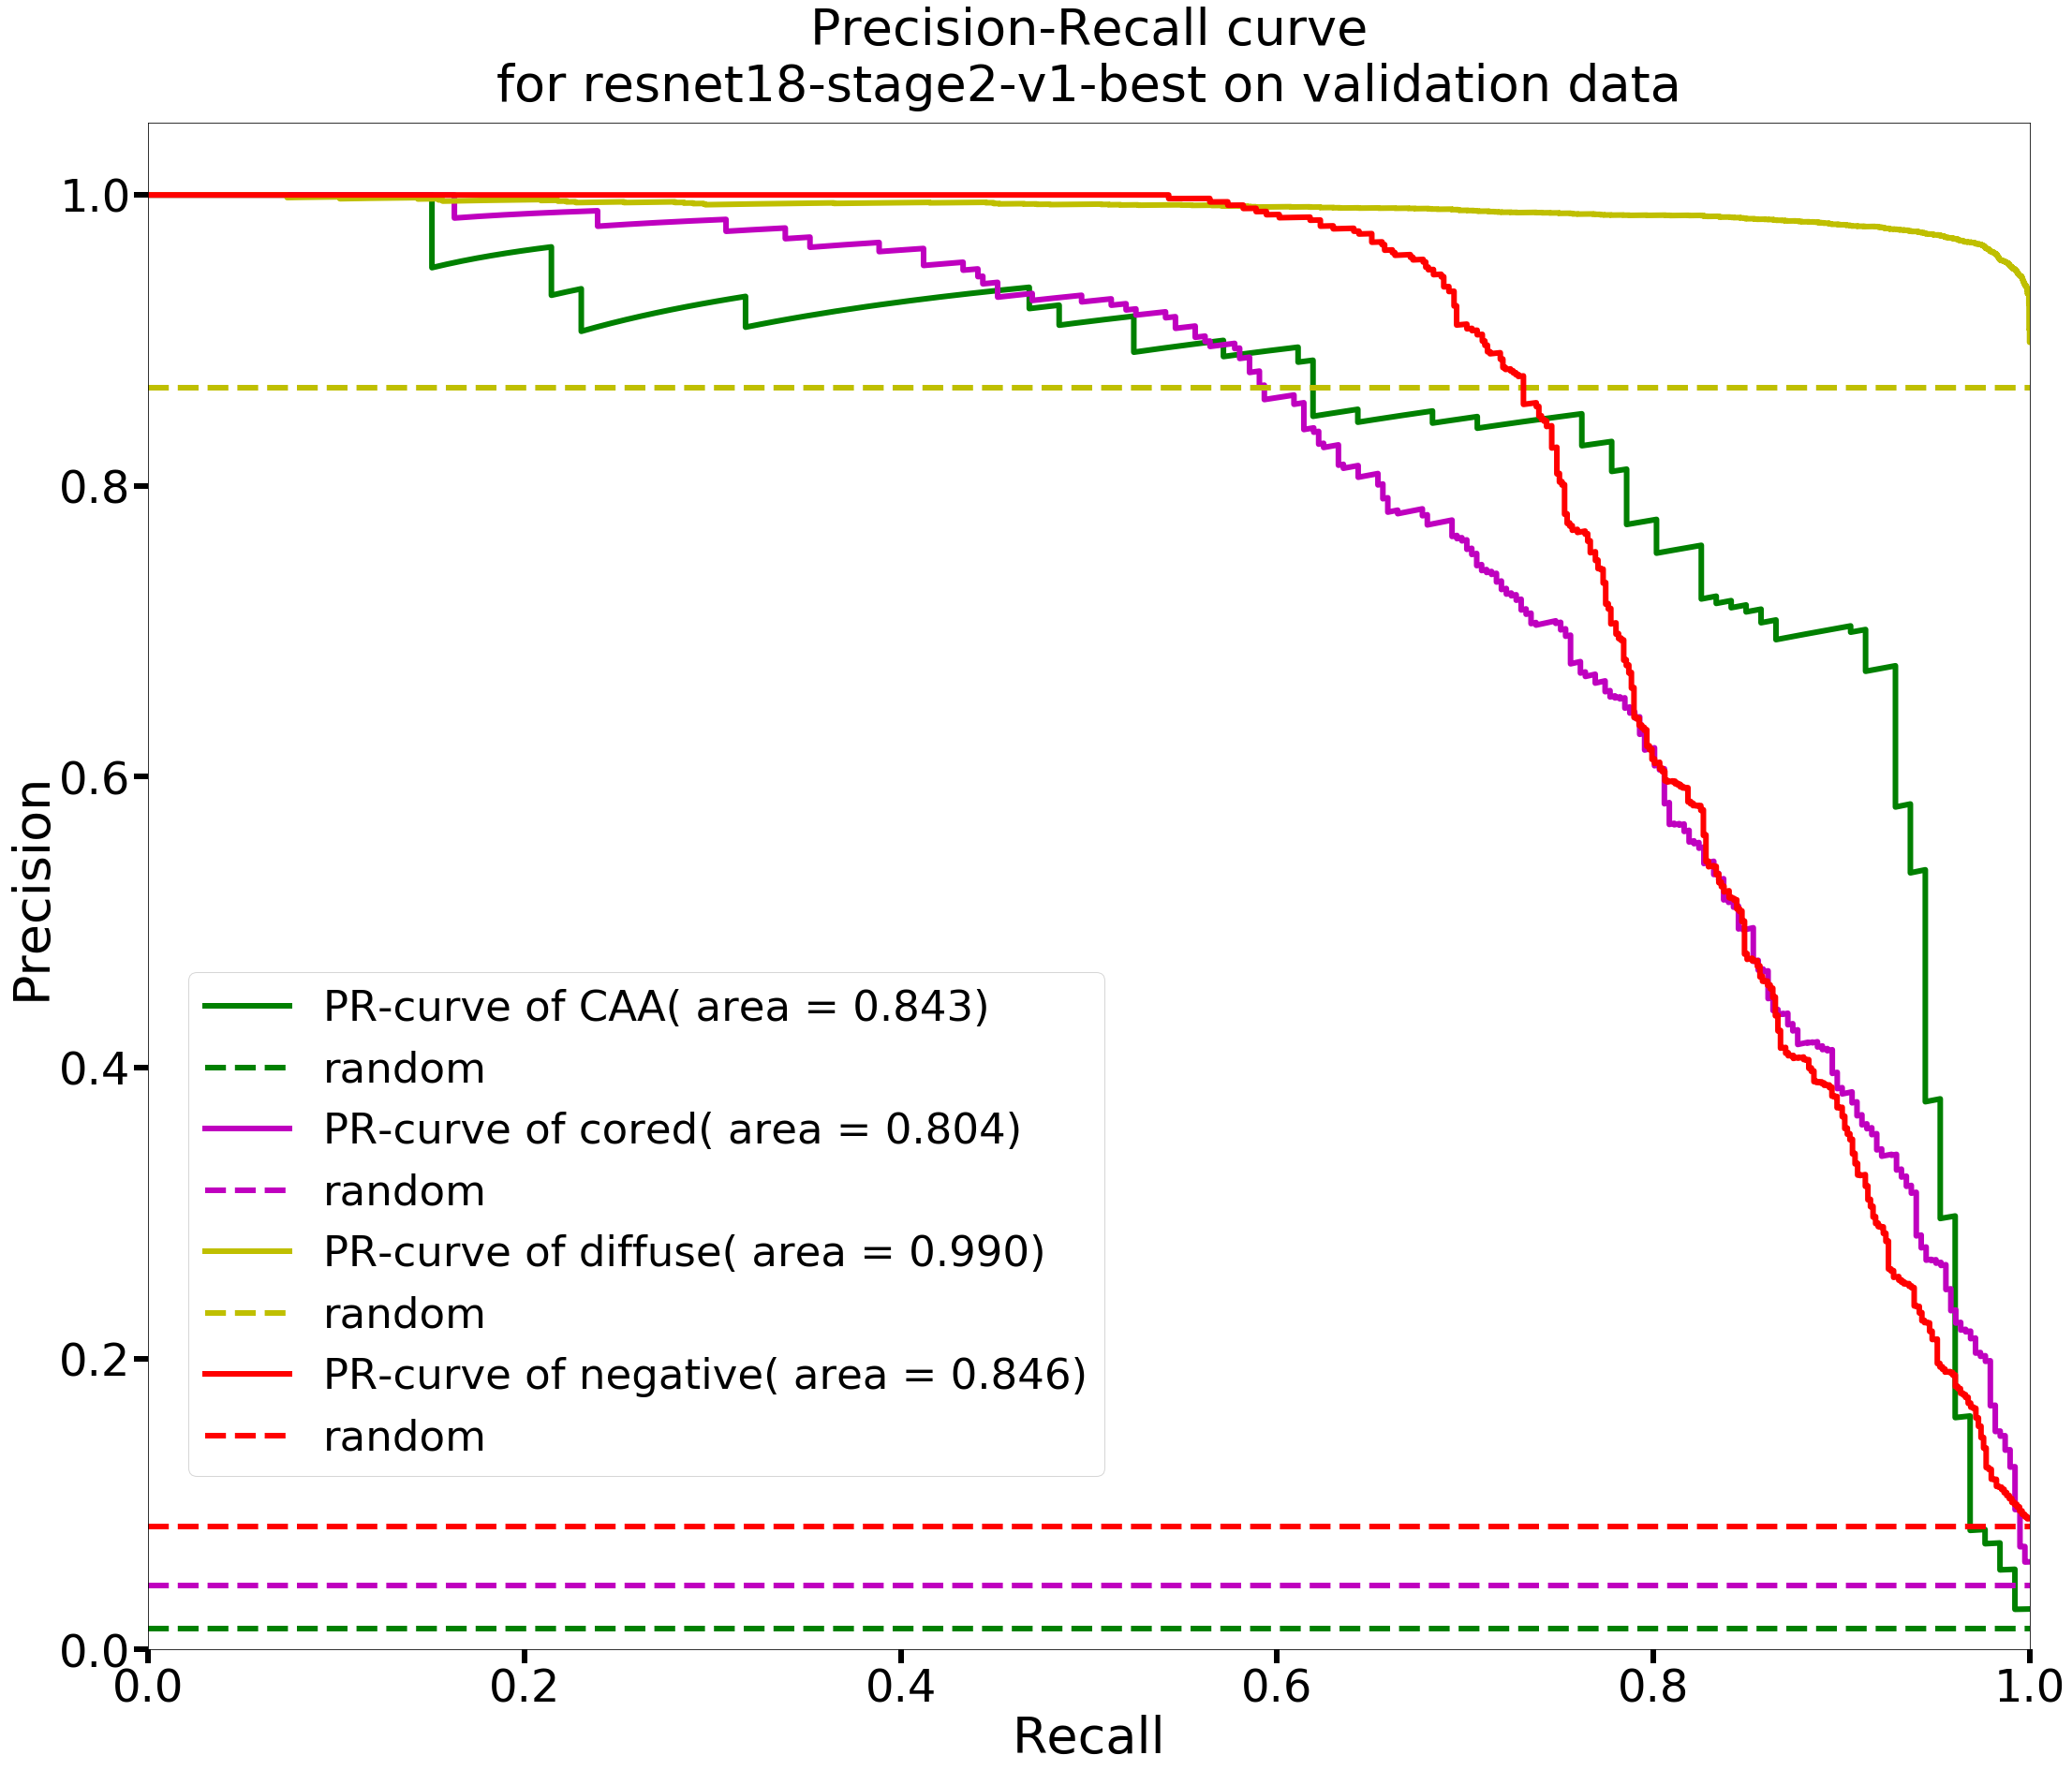

In [44]:
roc = plot.roc(valid_preds.numpy(), valid_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.model_dir, f'{model_name}_roc_plot.png'),
         model_name=model_name, dataset='validation')
prc = plot.prc(valid_preds.numpy(), valid_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.model_dir, f'{model_name}_prc_plot.png'),
         model_name=model_name, dataset='validation')

metrics['results']['validation'] = {**metrics['results']['validation'], **roc, **prc}

# Test Set

In [27]:
learn.data.valid_dl = data_test.train_dl
# learn = learn.to_fp16()
# learn.validate(metrics=[acc_05, f_score])

### Get predictions

In [28]:
test_preds, test_y, test_losses = learn.get_preds(with_loss=True)

In [29]:
torch.save(test_preds, os.path.join(cfg.output_path, f'{model_name}_test_preds.pt'))
torch.save(test_y, os.path.join(cfg.output_path, f'{model_name}_test_y.pt'))
torch.save(test_losses, os.path.join(cfg.output_path, f'{model_name}_test_losses.pt'))

In [14]:
test_preds = torch.load(os.path.join(cfg.output_path, f'{model_name}_test_preds.pt'))
test_y = torch.load(os.path.join(cfg.output_path, f'{model_name}_test_y.pt'))
test_losses = torch.load(os.path.join(cfg.output_path, f'{model_name}_test_losses.pt'))

### Calculate Evaluation Metrics

In [45]:
metrics['results']['test']['losses_mean'] = test_losses.mean().item()
metrics['results']['test']['losses_sum'] = test_losses.sum().item()

metrics['results']['test'] = {**metrics['results']['test'], 
                              **utils.calc_threshold_metric_score(y=test_y,
                                                                  preds=test_preds,
                                                                  metrics=threshold_metrics,
                                                                  classes=learn.data.classes)}

### Show a sample of results

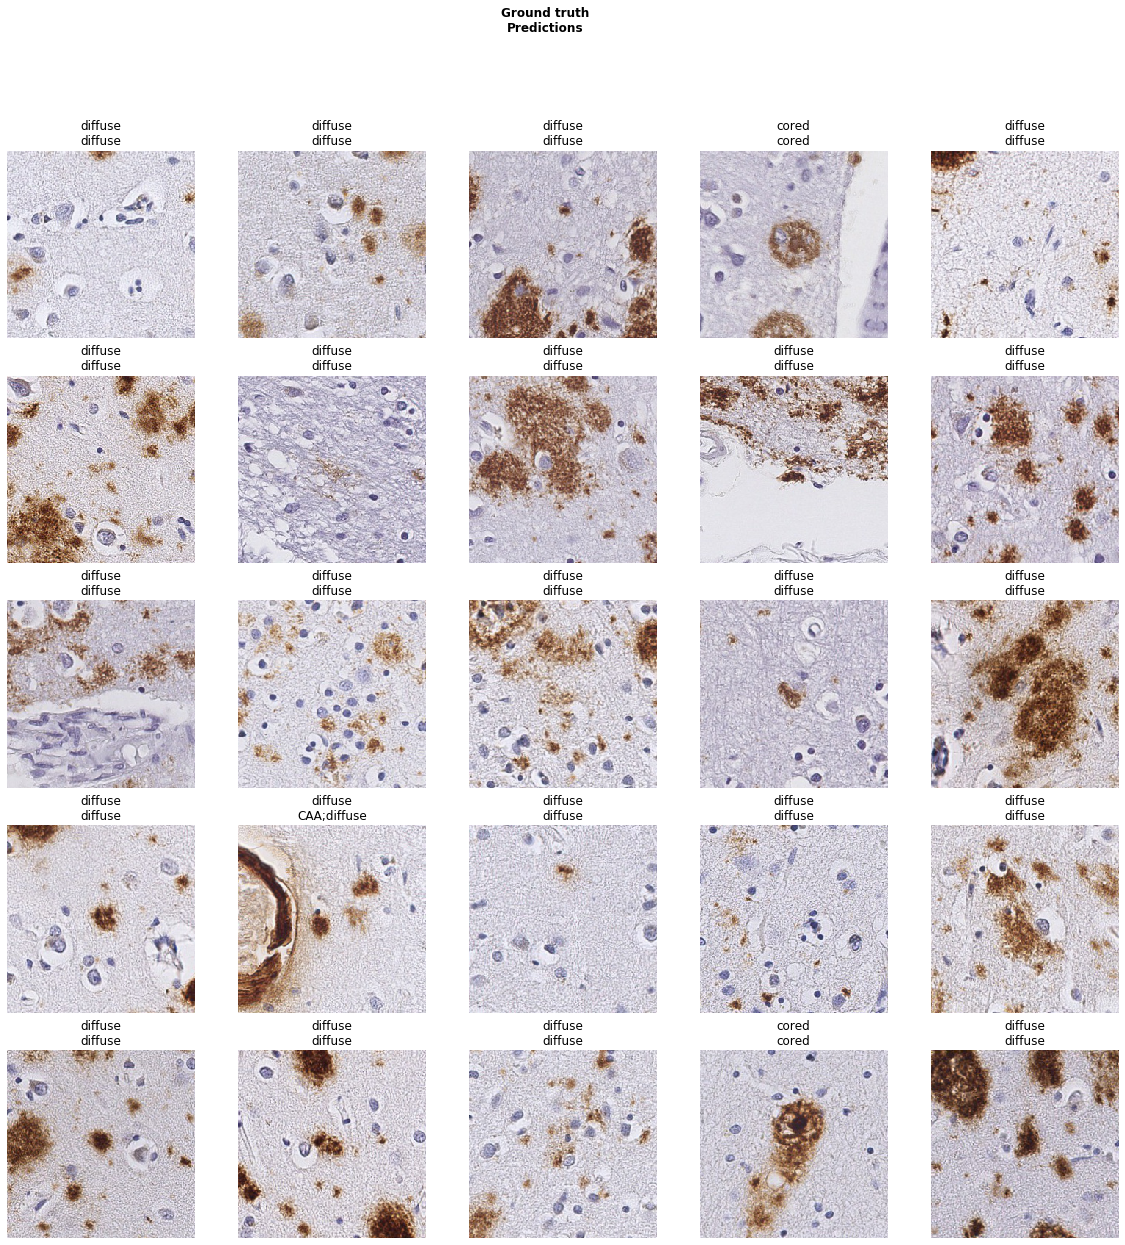

In [46]:
learn.show_results()

### Plot top losses

In [ ]:
plot.top_losses(preds=test_preds,
                y=test_y,
                losses=test_losses,
                learner=learn)

### Plot top losses - Cored

In [ ]:
plot.top_losses(preds=test_preds,
                y=test_y,
                losses=test_losses,
                learner=learn,
                target_class='cored')


### ROC PRC Curve Plot

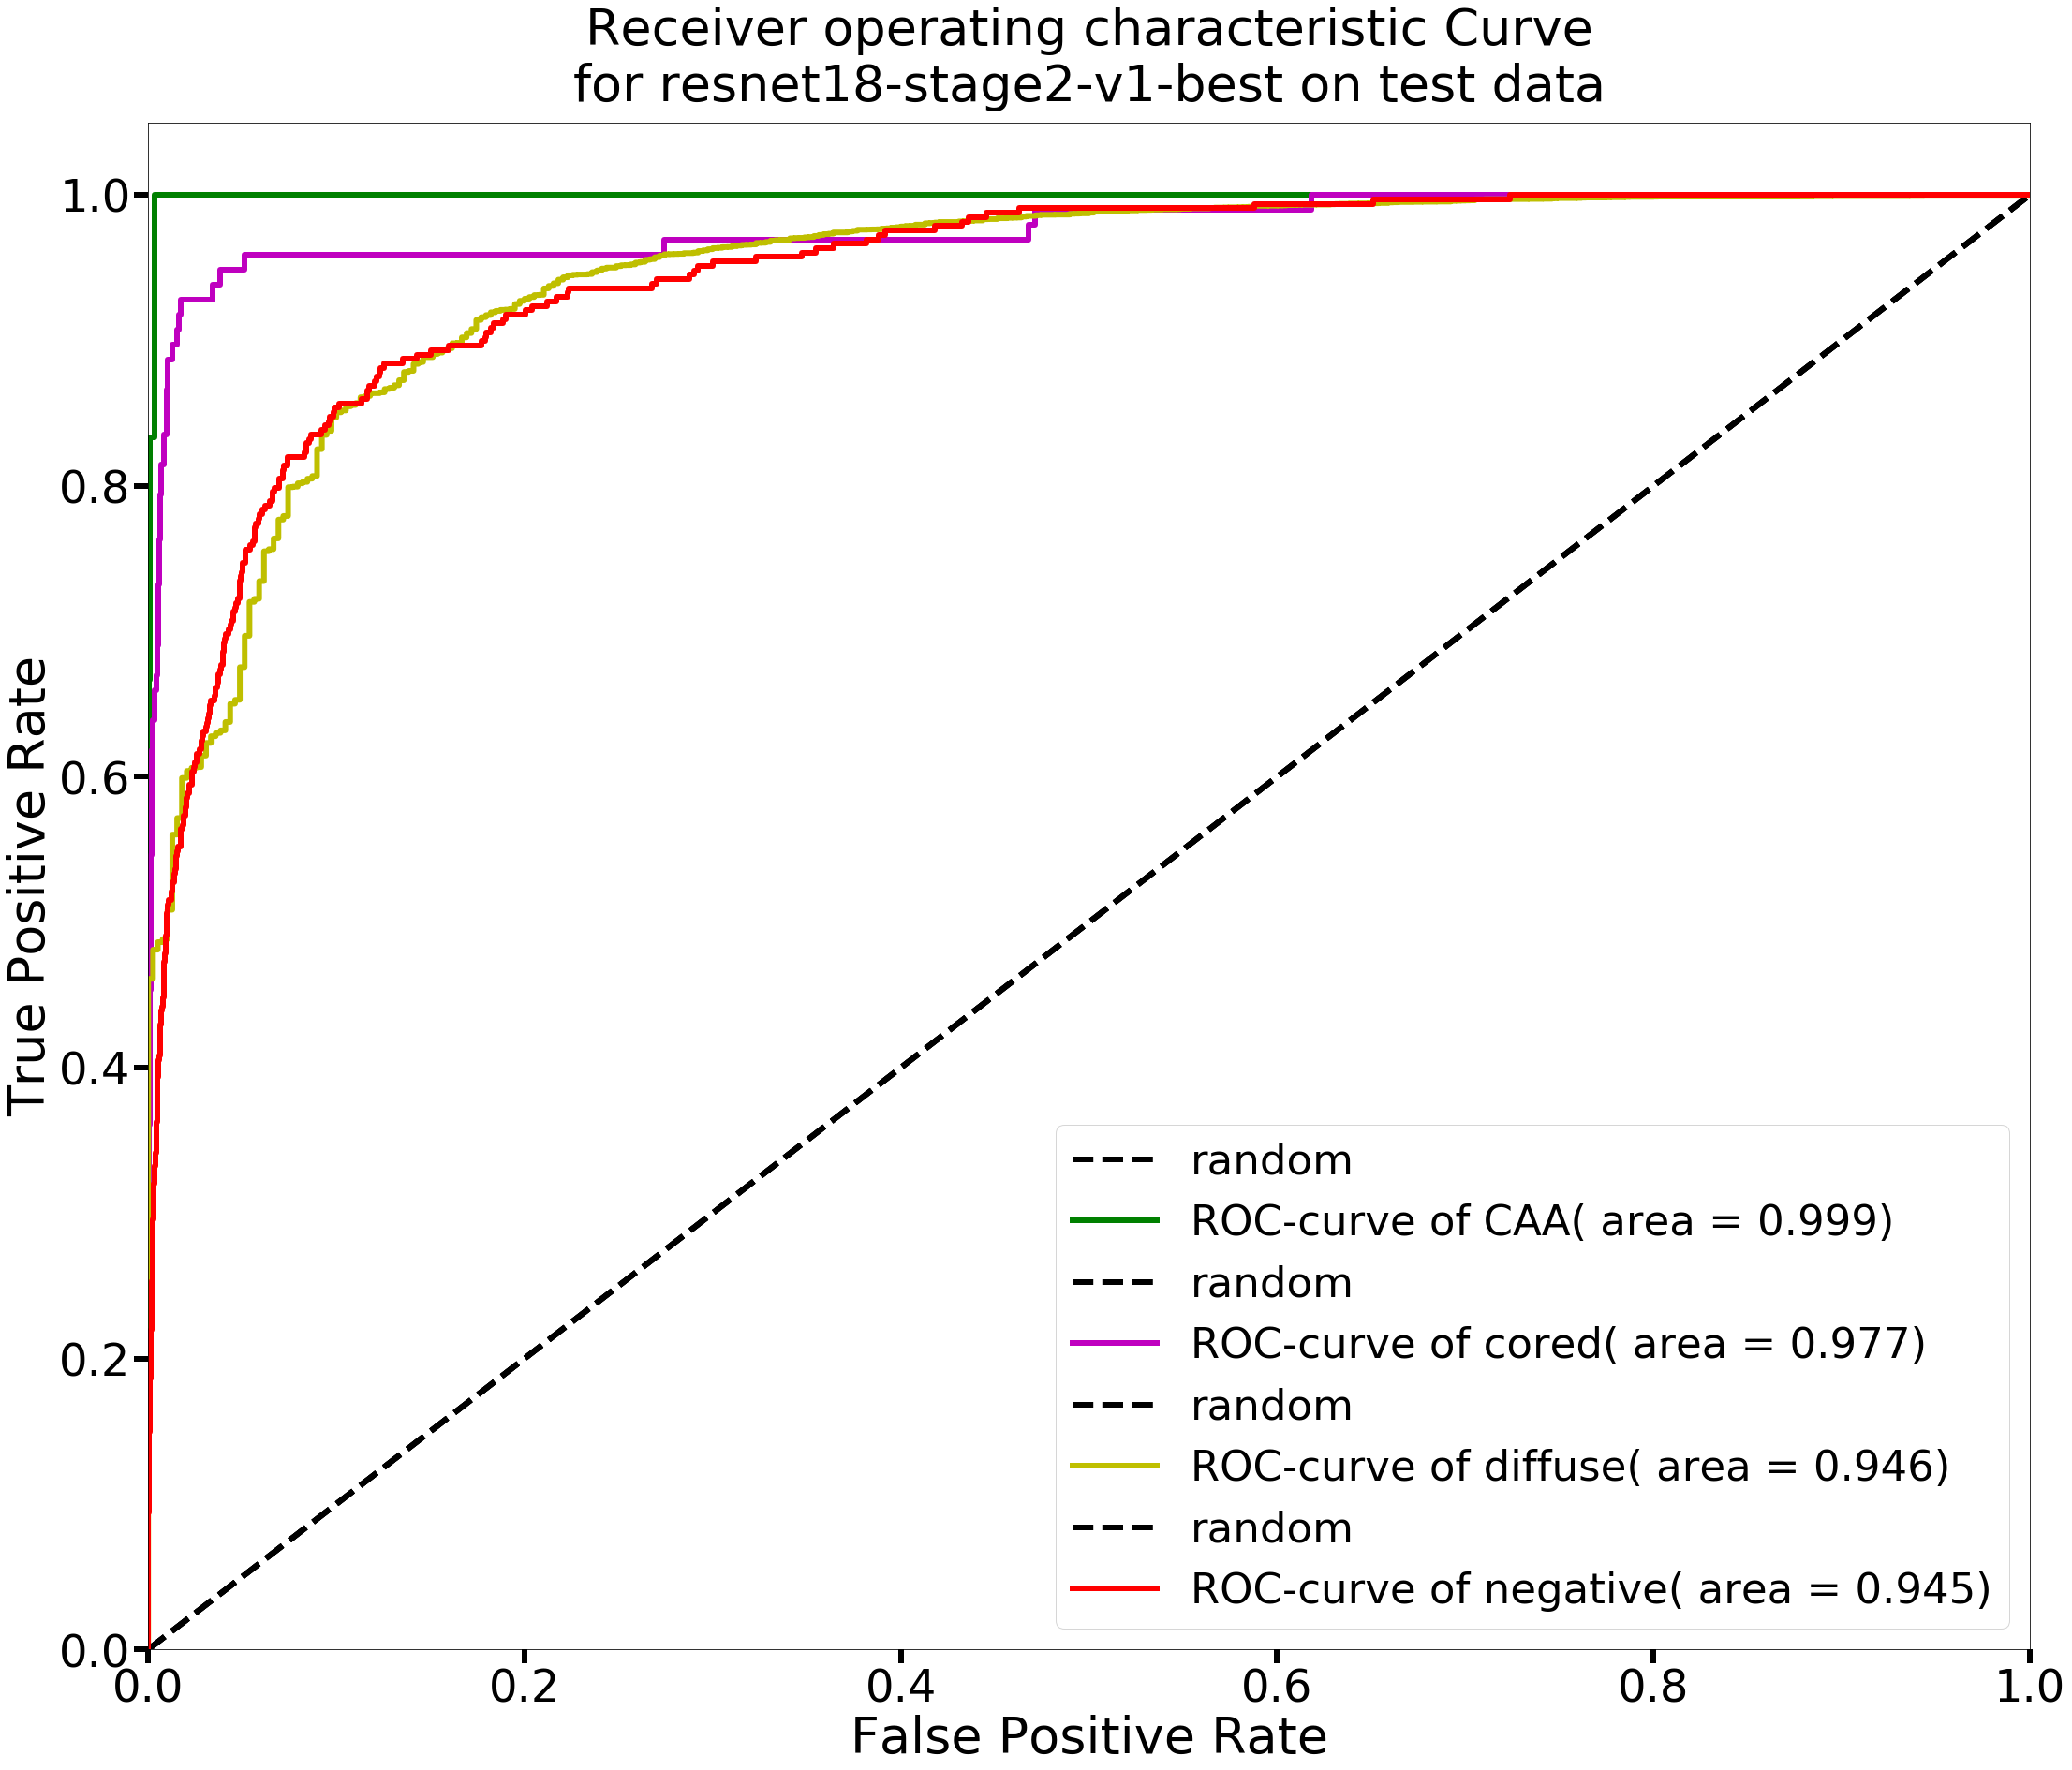

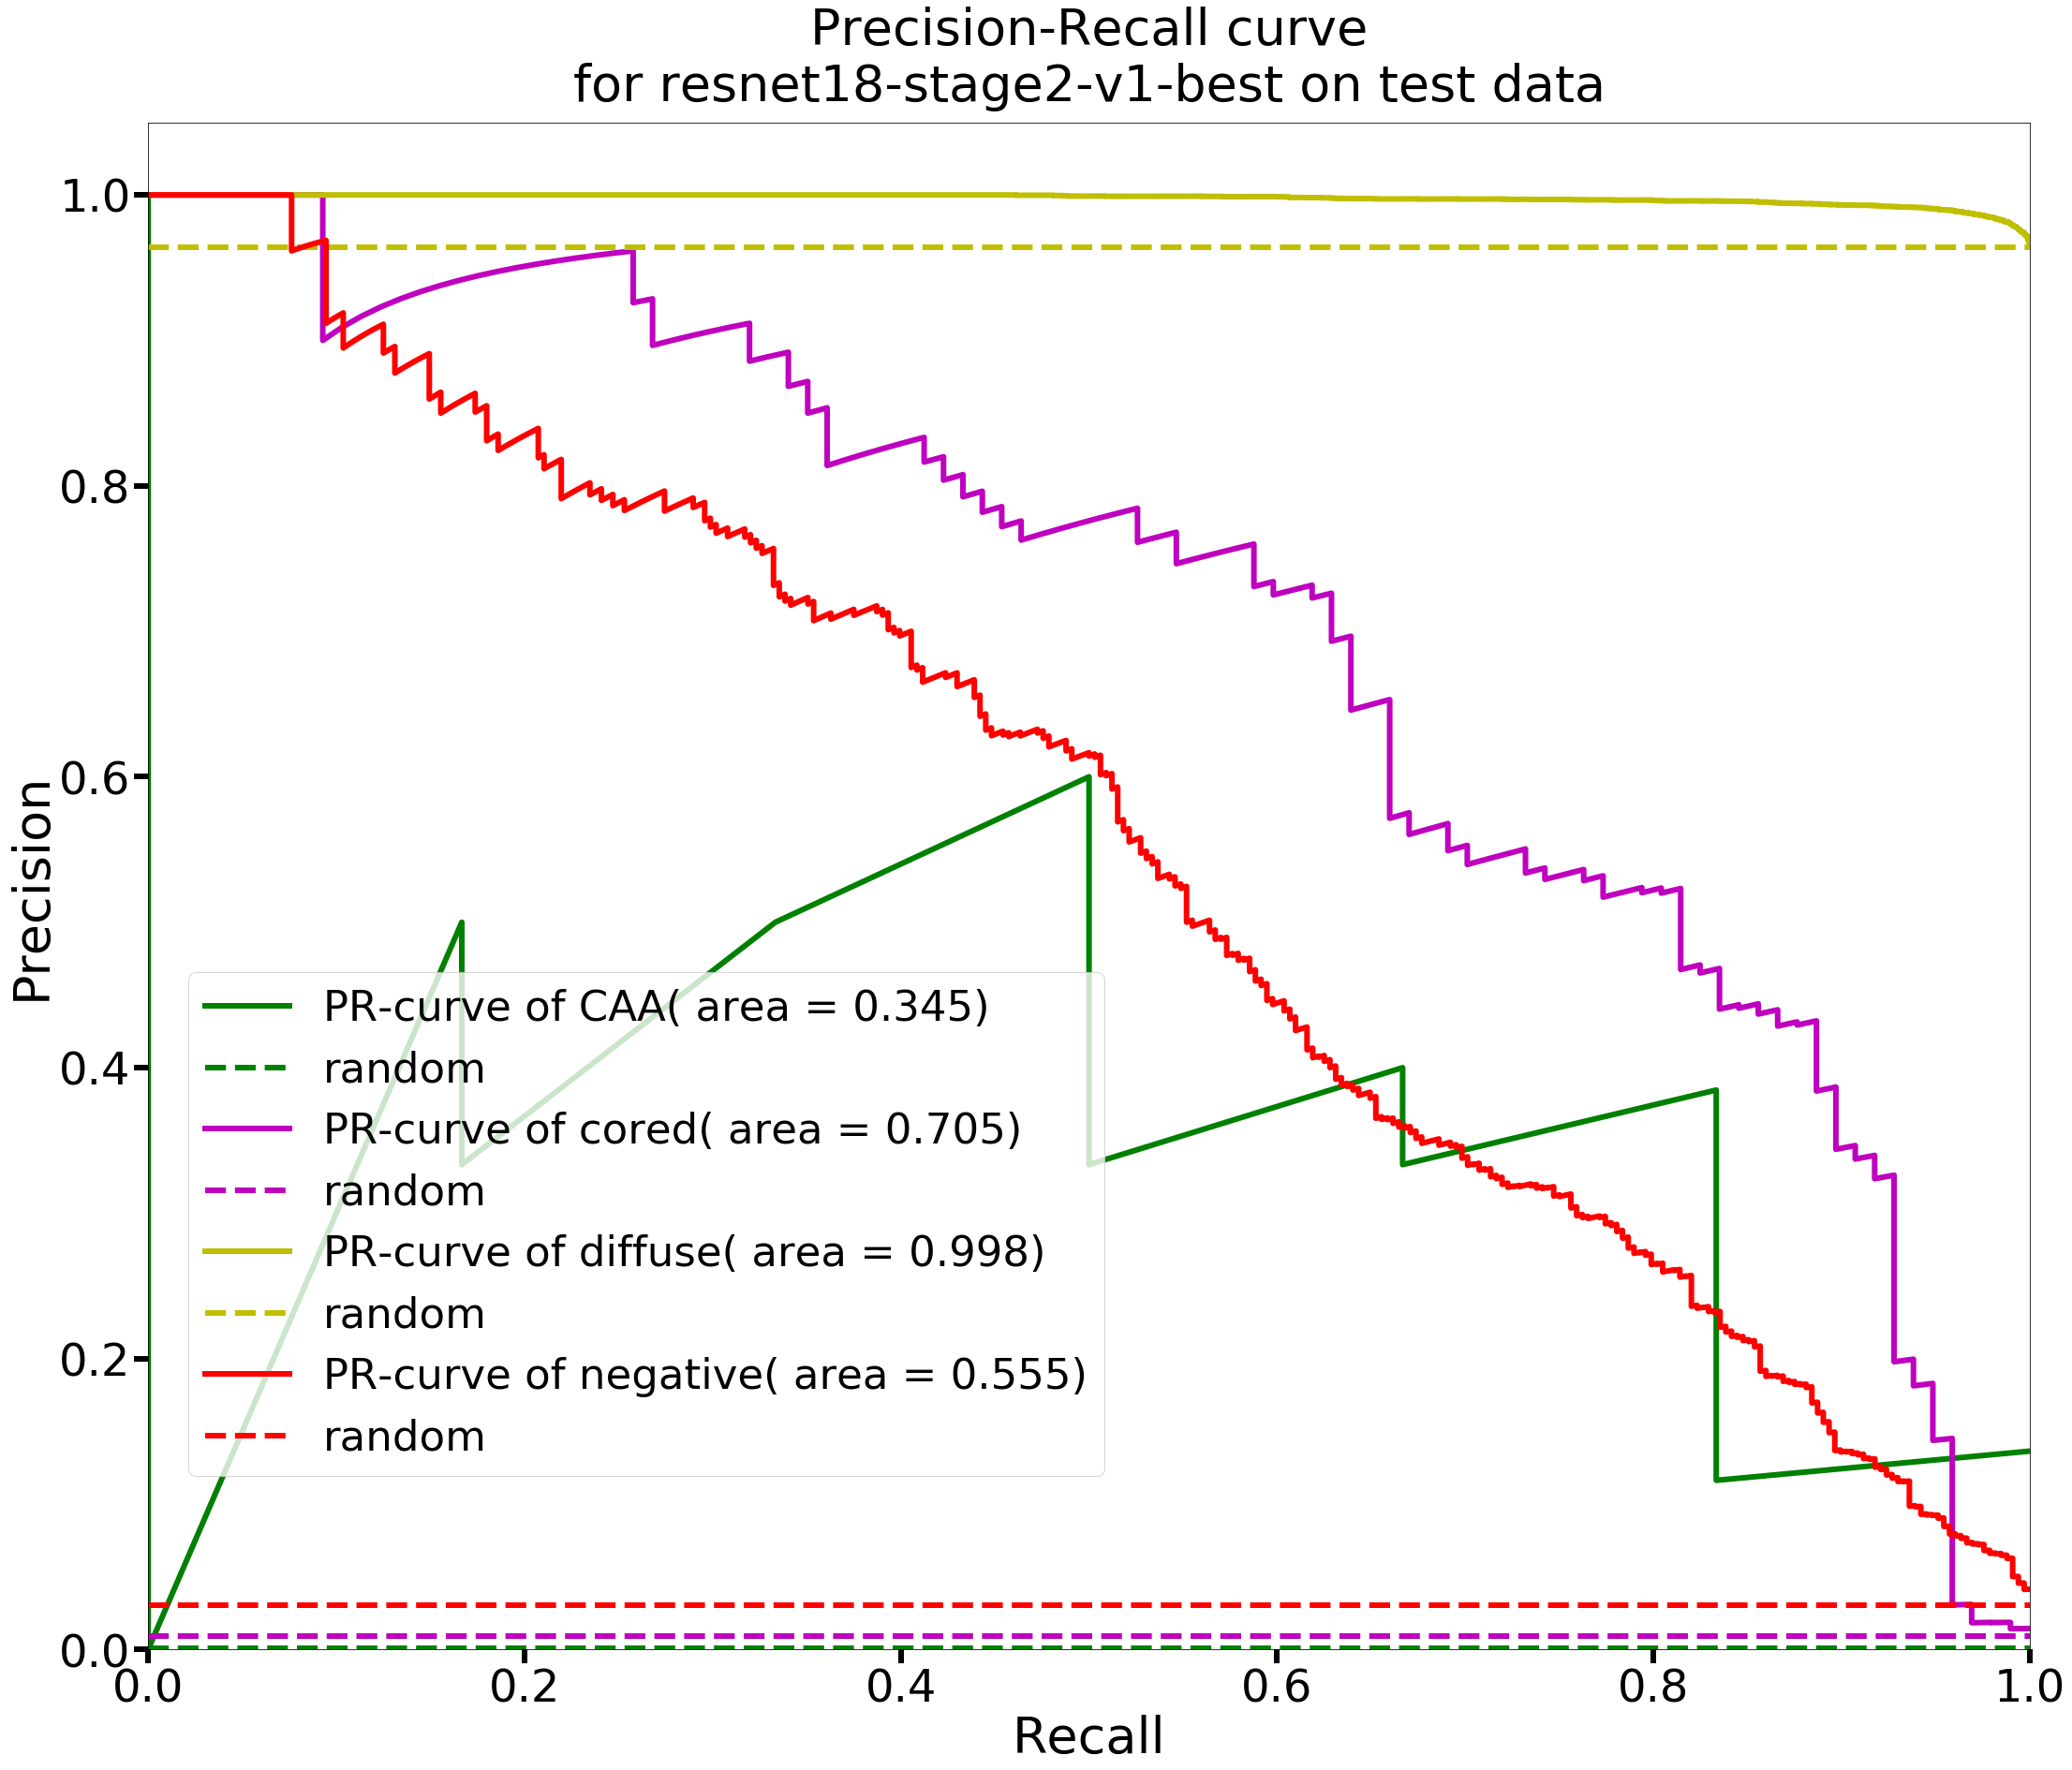

In [47]:
roc = plot.roc(test_preds.numpy(), test_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.model_dir, f'{model_name}_roc_plot_test.png'),
         model_name=model_name, dataset='test')
prc = plot.prc(test_preds.numpy(), test_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.model_dir, f'{model_name}_prc_plot_test.png'),
         model_name=model_name, dataset='test')
metrics['results']['test'] = {**metrics['results']['test'], **roc, **prc}

In [49]:
from pprint import pprint
pprint(metrics)

{'data': {'test': 'data/CSVs/test_multilabel.csv',
          'train': 'data/CSVs/train_multilabel.csv',
          'validation': 'data/CSVs/validation_multilabel.csv'},
 'meta': {'date': '2020_01_14',
          'experiment': 'original_w_negative',
          'model': 'resnet18',
          'model_name': 'resnet18-stage2-v1-best'},
 'results': {'test': {'AUPRC_#CAA': 0.34477150756220526,
                      'AUPRC_#cored': 0.7052317963247077,
                      'AUPRC_#diffuse': 0.9976543485980395,
                      'AUPRC_#negative': 0.5545563286144763,
                      'AUROC_#CAA': 0.9991211840888067,
                      'AUROC_#cored': 0.9771299253757899,
                      'AUROC_#diffuse': 0.9455577033746994,
                      'AUROC_#negative': 0.9448713744860562,
                      'accuracy_score_#CAA_@0.05': 0.9828032544378699,
                      'accuracy_score_#CAA_@0.10': 0.9882581360946746,
                      'accuracy_score_#CAA_@0.15': 0.9900

In [50]:
utils.save_json(metrics, os.path.join(cfg.results_dir, f'{model_name}_{cfg.run_date}.json'))

In [52]:
%%bash -s "$cfg.results_dir" "$cfg.gs_results_dir"
gsutil cp -r "$1" "$2"

Copying file:///mnt/disks/disk-1/data/original_w_negative/results/resnet18-stage2-v1-best_2020_01_14.json [Content-Type=application/json]...
/ [1 files][ 46.3 KiB/ 46.3 KiB]                                                
Operation completed over 1 objects/46.3 KiB.                                     


In [53]:
%%bash -s "$cfg.model_dir" "$cfg.gs_model_dir"
gsutil cp -r "$1" "$2"

Copying file:///mnt/disks/disk-1/data/original_w_negative/model/resnet18-stage2-v1-best_prc_plot_test.png [Content-Type=image/png]...
Copying file:///mnt/disks/disk-1/data/original_w_negative/model/resnet18-stage2-v1-best_roc_plot.png [Content-Type=image/png]...
Copying file:///mnt/disks/disk-1/data/original_w_negative/model/resnet18-stage1-v1.pth [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/disk-1/data/original_w_negative/model/resnet18-stage2-v1-best_roc_plot_test.png [Content-Type=image/png]...
\ [4 files][ 49.6 MiB/ 49.6 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///mnt/disks/disk-1/data/original_w_negative/model/resnet18-stage2-v1-best.pth [Content-Type=application/octet-stream]...
Copyi